In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
from pandana.loaders import osm
import pandana
%pylab inline

import numpy as np
import osmnx as ox
import networkx as nx
import peartree
import sys, os
import geopandas as gpd
import rasterio
from pandana.loaders import osm
from shapely.geometry import Point
import mplleaflet as mpll
from osgeo import ogr
from math import ceil, cos, pi
import geocoder

import GOSTnet as gn
from make_fishnet import make_fishnet

Populating the interactive namespace from numpy and matplotlib
peartree version: 0.6.0 
networkx version: 2.2 
matplotlib version: 2.2.2 
osmnx version: 0.8.2 


In [2]:
from mapboxgl.utils import *
from mapboxgl.viz import *

In [3]:
fig_kwargs={'figsize': [10, 10]}
bmap_kwargs={'suppress_ticks': False,'epsg': '4326'}
plot_kwargs={'cmap': 'viridis', 's': 8, 'edgecolor': 'none'}
hex_plot_kwargs = {'gridsize':40,
                   'alpha':0.9, 
                   'cmap':'viridis_r', 
                   'edgecolor':'none'}

## Mapping pedestrian accessibility

#### 1. Get bounding box from geocoder

In [4]:
city = ("Ulaan Baatar")
city = geocoder.arcgis(city)

In [5]:
bbox = gpd.GeoDataFrame(city.bbox).T

In [6]:
bbox.columns=['lat','lon']
bbox['geometry'] = (list(zip(bbox.lon,bbox.lat)))
bbox['geometry'] = bbox.geometry.apply(lambda x: Point(x))
bbox.set_geometry(bbox['geometry'])

,lat,lon,geometry
northeast,48.02271,106.99824,POINT (106.9982400000001 48.02271000000007)
southwest,47.79271,106.76824,POINT (106.7682400000001 47.79271000000006)


In [7]:
ax = bbox.plot()
mpll.display(fig=ax.figure)

#### 2. Get POIs, road network and fishnet
format: osm.node_query(lat_min, lng_min, lat_max, lng_max, tags=None)

In [8]:
city.bbox

{'northeast': [48.02271000000007, 106.99824000000005],
 'southwest': [47.79271000000006, 106.76824000000006]}

In [9]:
coords = [city.bbox['southwest'][0], city.bbox['southwest'][1], city.bbox['northeast'][0], city.bbox['northeast'][1]] 
coords

[47.79271000000006, 106.76824000000006, 48.02271000000007, 106.99824000000005]

In [11]:
pois_business = pd.read_csv('pois_business.csv')
pois_business = gpd.GeoDataFrame(pois_business)

pois_res = pd.read_csv('pois_res.csv')
pois_res = gpd.GeoDataFrame(pois_res)

In [14]:

pois_business['geometry'] = (list(zip(pois_business.lon,pois_business.lat)))
pois_business['geometry'] = pois_business.geometry.apply(lambda x: Point(x))

pois_res['geometry'] = (list(zip(pois_res.lon,pois_res.lat)))
pois_res['geometry'] = pois_res.geometry.apply(lambda x: Point(x))

In [28]:
print(pois_res.shape)
pois_res = pois_res[pois_res['type'] != 'bank']
print(pois_res.shape)

(6744, 7)
(6487, 7)


In [16]:
network = osm.pdna_network_from_bbox(coords[0], coords[1], coords[2], coords[3])

Requesting network data within bounding box from Overpass API in 1 request(s)
Posting to http://www.overpass-api.de/api/interpreter with timeout=180, "{'data': '[out:json][timeout:180];(way["highway"]["highway"!~"motor|proposed|construction|abandoned|platform|raceway"]["foot"!~"no"]["pedestrians"!~"no"](47.79271000,106.76824000,48.02271000,106.99824000);>;);out;'}"
Downloaded 9,108.7KB from www.overpass-api.de in 1.66 seconds
Downloaded OSM network data within bounding box from Overpass API in 1 request(s) and 1.87 seconds
Returning OSM data with 75,337 nodes and 10,050 ways...
Edge node pairs completed. Took 17.94 seconds
Returning processed graph with 13,857 nodes and 18,974 edges...
Completed OSM data download and Pandana node and edge table creation in 22.25 seconds


In [17]:
nodes_gdf = gpd.GeoDataFrame(network.nodes_df)
nodes_gdf['geometry'] = (list(zip(nodes_gdf.x,nodes_gdf.y)))
nodes_gdf['geometry'] = nodes_gdf.geometry.apply(lambda x: Point(x))

In [18]:
make_fishnet('grid_.shp',coords[1], coords[3], coords[0], coords[2],200,200) # takes xmin, xmax, ymin, ymax

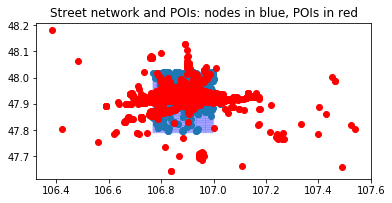

In [21]:
grid=gpd.read_file('grid_.shp')
ax = grid.plot(facecolor='w',edgecolor='b',lw=0.1,figsize=[6,6])
nodes_gdf.plot(ax=ax)
pois_res.plot(ax=ax,color='r')
ax.set_title('Street network and POIs: nodes in blue, POIs in red');

#### 3. Plot accessibility from any node to nearest amenity

In [29]:
network.precompute(2000) # precomputes the nodes that are reachable within 2000 meters

Variables to define:
 - distance: compute accessibility within this distance from any point
 - num_pois: calculate distance to this many amenities [ie. to first, second, third ... n amenities]

In [31]:
distance = 2000
num_pois = 5
#num_categories = len(amenities) + 1 #one for each amenity, plus one extra for all of them combined

In [44]:
network.set_pois(category='all', maxdist = distance,maxitems = num_pois,x_col=pois_res['lon'], y_col=pois_res['lat'])

all_access = network.nearest_pois(distance=distance, category='all', num_pois=num_pois)
print('{:,} nodes'.format(len(all_access)))
all_access.head(5)

13,857 nodes


,1,2,3,4,5
id,,,,,
57677284,0.000000,196.684006,196.684006,196.684006,196.684006
57677289,39.020000,39.020000,39.695999,81.661003,81.661003
57677290,0.000000,0.000000,42.945999,87.447998,109.978996
57677291,27.436001,27.436001,27.436001,27.436001,43.673000
200776606,43.027000,101.959999,106.961998,106.961998,116.478996


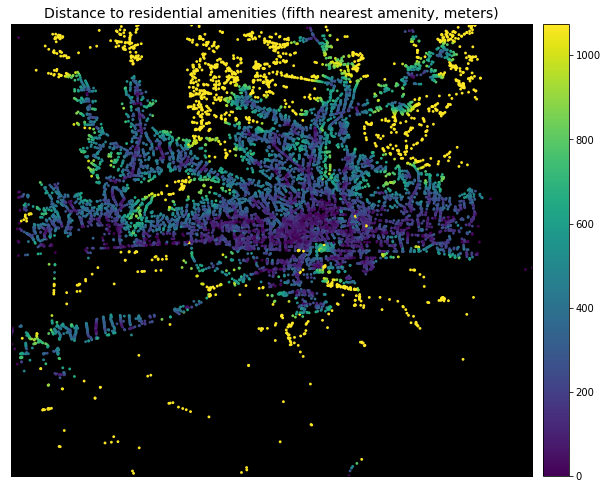

In [46]:
# distance to the nearest amenity of any type
n = 5
bmap, fig, ax = network.plot(all_access[n], plot_kwargs=plot_kwargs, fig_kwargs=fig_kwargs)
ax.set_facecolor('k')
ax.set_title('Distance to residential amenities (fifth nearest amenity, meters)', fontsize=14);

#### 4. Fix the distances to the grid

In [35]:
grid.to_csv('UB_grid')

In [36]:
grid['centroid'] = grid.geometry.centroid

In [37]:
grid['nearest_node'] = np.nan
grid['nearest_node'] = network.get_node_ids(grid.centroid.x,grid.centroid.y,mapping_distance=10)
grid.isnull().sum()

FID             0
geometry        0
centroid        0
nearest_node    0
dtype: int64

In [38]:
grid.head(2)

,FID,geometry,centroid,nearest_node
0,0,"POLYGON ((106.7682400000001 48.02271000000007,...",POINT (106.7691383152842 48.02137285287125),4214530952
1,1,"POLYGON ((106.7682400000001 48.02003570574244,...",POINT (106.7691383152842 48.01869855861362),4214530952


In [47]:
# horrible code, improve
distances = []
for i in range(grid.shape[0]):
    node = grid.nearest_node[i]
    distance = all_access.loc[node,5]
    distances.append(distance)  

In [48]:
grid['distances'] = distances

[Text(0.5,1,'Ulaan Baatar: Meters walk to fifth-nearest amenity')]

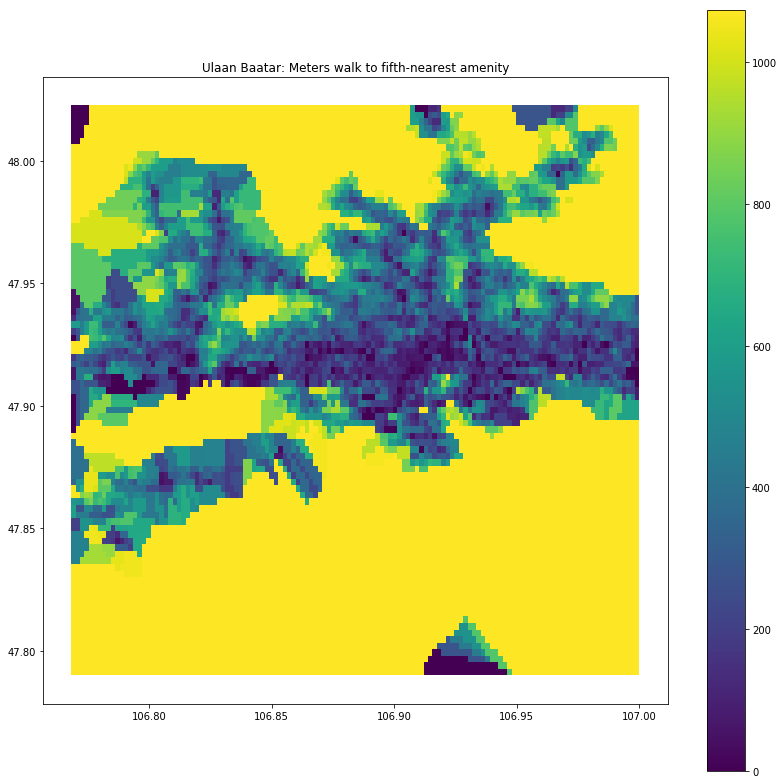

In [49]:
city = 'Ulaan Baatar'
ax = grid.plot(column='distances',figsize=[14,14],legend=True)
ax.set(title = '{}: Meters walk to fifth-nearest amenity'.format(city))

In [49]:
grid['lon'] = [a.x for a in grid.centroid]
grid['lat'] = [a.y for a in grid.centroid]

In [44]:
a = grid.loc[0,'centroid'].x

106.76913831528418

In [51]:
# Create a geojson file export from a Pandas dataframe
df_to_geojson(grid, filename='grid.geojson',
              properties=['distances'])

{'type': 'file', 'filename': 'grid.geojson', 'feature_count': 11223}

In [54]:
token = "pk.eyJ1Ijoibmo5MzUiLCJhIjoiY2pzOW1pdGluMGVpeTN5bnhyZHRpcHdycSJ9.uQWY2hDAjKaxMQsoOzwfSQ"

In [58]:
viz = CircleViz('grid.geojson',
                access_token=token,
                height='600px',
                radius=1.5,
                #color_property = "Category",
                color_stops = color_stops,
                center = (106.91, 47.92),
                zoom = 12,
                #stroke_width=0.8,
                color_default='yellow',
                below_layer = 'waterway-label'
            )

viz.style='mapbox://styles/mapbox/satellite-streets-v9'
viz.show()

In [56]:
measure = 'distances'
heatmap_color_stops = create_color_stops([0.01, 0.25, 0.5, 0.75, 1], colors='RdPu')
heatmap_radius_stops = [[0, 3], [14, 100]]
color_breaks = [round(grid[measure].quantile(q=x*0.1), 2) for x in range(2,10)]
color_stops = create_color_stops(color_breaks, colors='Spectral')
heatmap_weight_stops = create_weight_stops(color_breaks)

viz = HeatmapViz([], 
                 disable_data_join=True,
                 access_token=token,
                 vector_url='mapbox://rsbaumann.2pgmr66a',
                 vector_layer_name='healthcare-points-2yaw54',
                 weight_property='Avg Medicare Payments',
                 weight_stops=heatmap_weight_stops,
                 color_stops=heatmap_color_stops,
                 radius_stops=heatmap_radius_stops,
                 opacity=0.8,
                 center=(-95, 40),
                 zoom=3,
                 below_layer='waterway-label')

viz.show()

SyntaxError: keyword argument repeated (<ipython-input-56-02c8312235df>, line 20)

In [50]:
G

NameError: name 'G' is not defined